In [1]:
from Data import YahooData
from StockFeatureBuilder import FeatureData
from FeatureSelection import Feature_and_Splitting
from RandomForest import RandomForestAlgorithm
from ModelStatistics import Statistics

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

import json
import time
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date

import warnings
warnings.filterwarnings('ignore')

In [2]:
symbols = ['FB', 'AAPL', 'AMZN', 'NFLX']

start = date(2010, 1, 1)
end = date.today()

kind = 'Regression'
kind = 'Classification'

plt.style.use('ggplot')

Gathers yahoo data and creates multiple features.

In [3]:
if __name__ == '__main__':
    
    start_all = time.perf_counter()

    yho = YahooData(symbols, start, end)
    yho_data = yho.get_data()

    strc = FeatureData(yho_data, symbols, kind = kind, future = 2)
    data = strc.main(True)

    y_vals = data['Target']
    X_vals = data.drop(['Target'], axis = 1)
    X = X_vals.values

    print("Gathering all data took: {:0.4f} seconds\n".format(time.perf_counter() - start_all))
    print("Number of rows:", len(data))
    print("Number of columns:", len(X_vals.columns))
    total = len(data) * len(data.columns)
    print("Total Data Points: {}".format(total))

Gathering Data...

Gathering the data took: 2.5668 seconds

Creating Features...

Changing data type from 64-bit to 32-bit...
Type conversion took: 0.0020

Creating Bars...
Bar creation took: 1.0248

Taking percentage change...
Percentage change took: 0.1523

Taking percentage change...
Percentage change took: 0.0074

Taking Derivatives
Derivatives took: 0.1631

Taking Multiple STDV...
Multiple STDV took: 0.3652

Taking Multiple STDV Derivative...
Multiple Derivative STDV took: 0.0949

Calculating EMAs...
EMAs took: 0.2927

Getting speed of bars...
Speed took: 0.1769

Taking derivative of speed of bars...
Derivative of Speed took: 0.0644

Calculating EMAs Differences...
EMAs Differences took: 0.1419

Creating Pin bars...
Pin Bar took: 0.3439

Taking bar ohlc differences...
Bar Diff took: 0.7310

Taking derivative of bar ohlc differences...
Derivative of Bar Diff took: 0.0260

Getting bar percentages...
Bar percentages took: 0.2981

Creating the features took: 3.8862 seconds

Creating T

Runs a Feature Selection

In [4]:
FnS = Feature_and_Splitting(X_vals, y_vals, test_size = 0.2, K_feat = 50, columns = X_vals.columns)
new_feat, dropped, X_scaler, X_train_selected, X_test_selected, y_train, y_test = FnS.main()

print("Number of new features:", len(new_feat))
rows = len(data)
cols = len(new_feat)

total = rows * cols
print("Total Data Points: {}".format(total))

Feature Selection...
-------------------------
Feature Selection took: 0.0865 seconds

Number of new features: 50
Total Data Points: 434650


Runs multiple random forest models with various trees.

Random Forest Estimator: 20 of 300
Random Forest Estimator: 40 of 300
Random Forest Estimator: 60 of 300
Random Forest Estimator: 80 of 300
Random Forest Estimator: 100 of 300
Random Forest Estimator: 120 of 300
Random Forest Estimator: 140 of 300
Random Forest Estimator: 160 of 300
Random Forest Estimator: 180 of 300
Random Forest Estimator: 200 of 300
Random Forest Estimator: 220 of 300
Random Forest Estimator: 240 of 300
Random Forest Estimator: 260 of 300
Random Forest Estimator: 280 of 300
Random Forest Estimator: 300 of 300


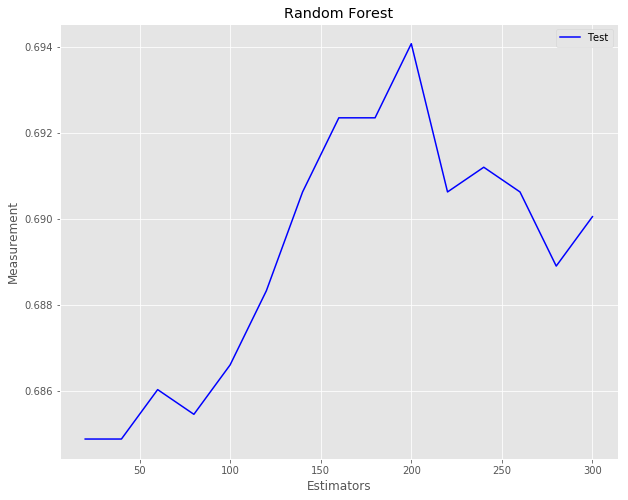

Random Forest Took: 45.65868775299987 seconds


In [5]:
start = time.perf_counter()

rf = RandomForestAlgorithm(X_train_selected, X_test_selected, y_train, y_test)

n_jobs = -1
n_estimators = 300
step_factor = 20
axis_step = int(n_estimators/step_factor)
if kind == 'Regression':
    train_res, test_res, estimators, last_model = rf.random_forest_regressor(n_jobs, n_estimators, step_factor, axis_step)
    rf.graph(train_res, test_res, estimators, chart = 'Test')

else:
    train_res, test_res, estimators, last_model = rf.random_forest_classifier(n_jobs, n_estimators, step_factor, axis_step)
    rf.graph(train_res, test_res, estimators, chart = 'Test')

print("Random Forest Took: {} seconds".format(time.perf_counter() - start))

Chooses the amount of trees that gave the best results.

In [6]:
test_results = pd.concat([
    pd.DataFrame(test_res, columns = ['Results']), 
    pd.DataFrame(estimators, columns = ['Estimators'])], 
    axis = 1)

loc = test_results['Results'].idxmax()
trees = int(test_results.iloc[loc, -1])

print(f"Trees: {trees}")

print("Creating Best Model...")
print('-------------------------')
start = time.perf_counter()

if kind == 'Regression':
    Model = RandomForestRegressor(n_estimators = trees, n_jobs = -1)
    Model.fit(X_train_selected, y_train)
else:
    Model = RandomForestClassifier(n_estimators = trees, n_jobs = -1)
    Model.fit(X_train_selected, y_train)
    
print("Took: {} seconds".format(time.perf_counter() - start))

Trees: 200
Creating Best Model...
-------------------------
Took: 3.07198051999967 seconds


In [7]:
def model_feature_importances(model, model_features):
    importances = list(model.feature_importances_)
    feature_importances = [(feature, round(importance, 3))
                           for feature, importance in zip(model_features, importances)]
    sorted_feats = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    return sorted_feats

model_feat = model_feature_importances(Model, new_feat)
model_feat

[('pct: derivative', 0.076),
 ('high pct: derivative', 0.044),
 ('low pct: derivative', 0.043),
 ('volume - derivative', 0.042),
 ('close - derivative', 0.024),
 ('high - close: 12', 0.022),
 ('Speed / 10bars: derivative', 0.021),
 ('high - low: derivative', 0.02),
 ('low - open: derivative', 0.02),
 ('high - close: derivative', 0.02),
 ('Speed / 4bars: derivative', 0.019),
 ('Speed / 6bars: derivative', 0.019),
 ('close - open: derivative', 0.019),
 ('low - close: derivative', 0.019),
 ('low - derivative', 0.018),
 ('Speed / 2bars: derivative', 0.018),
 ('Speed / 14bars: derivative', 0.018),
 ('Speed / 20bars: derivative', 0.018),
 ('Speed / 24bars: derivative', 0.018),
 ('high - low', 0.018),
 ('high - open: derivative', 0.018),
 ('volume', 0.017),
 ('volume p - 20', 0.017),
 ('volume p - 24', 0.017),
 ('Speed / 8bars: derivative', 0.017),
 ('Speed / 12bars: derivative', 0.017),
 ('Speed / 22bars: derivative', 0.017),
 ('Speed / 26bars: derivative', 0.017),
 ('Speed / 28bars: derivat

For K-fold Cross Validation

In [8]:
def Filter_Values(X_vals, dropped):
    X_all = X_vals.drop(dropped, axis = 1)
    X_all = X_scaler.transform(X_all)
    
    return X_all

X_all = Filter_Values(X_vals, dropped)

In [9]:
start = time.perf_counter()

scores = cross_val_score(Model, X_all, y_vals, cv = 10, n_jobs = -1)

print("k-Fold took: {} seconds\n".format(time.perf_counter() - start))
print("Mean Scores: {}".format(scores.mean()))
print("STDV Scores: {}".format(scores.std()))
print("Confidence Interval ~ 95%: {0:0.4f}, {1:0.4f}".format(scores.mean() - scores.std() * 1.96, 
                                                   scores.mean() + scores.std() * 1.96))
print(f"\nScores: {scores}")

k-Fold took: 38.344368774999566 seconds

Mean Scores: 0.6774317070873314
STDV Scores: 0.07855861166556166
Confidence Interval ~ 95%: 0.5235, 0.8314

Scores: [0.72330654 0.74597701 0.67011494 0.73417722 0.6881473  0.67779056
 0.6858458  0.46375144 0.64096663 0.74423963]


Gets statistics and saves model with required data for later use. __NOTE__: This only works for classification models.

In [10]:
nan = np.array([0])
# Set scores = nan if you do not want to run K-Fold

S = Statistics(
    X_test_selected, y_test, Model, new_feat, X_scaler = X_scaler, 
    y_scaler = None, scores = scores, size = 3
)
stats = S.statistics()
file_name = 'YahooTomorrowDailyDoubleClassificationRF'
nick_name = 'YHO-DlyDble-RF'
S.save_all(file_name, nick_name)

Total Predictions: 0.1599%
Successfully created the directory /home/leoi137/Desktop/Resources/Algorithms/Algo. Trading/Machine Learning - v2/Modules - v1.00/YHO-DlyDble-RF
Total Predictions: 0.1599%


In [11]:
pd.DataFrame(stats['Accuracy'], index = ['Accuracy']).T

,Accuracy
All,0.693500
Bull,0.716700
Bear,0.734700
Stalled,0.687900
STDV,0.078559


In [12]:
conf_matrix = pd.DataFrame(stats['Confusion Matrix'])
conf_matrix

,-1,0,1
0,72,196,8
1,21,1005,43
2,5,260,129
